In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
import googlemaps
key = 'your_key'
gmaps = googlemaps.Client(key = key)
geocode_result = gmaps.geocode('target_address')
lat = geocode_result[0]['geometry']['location']['lat']
lng = geocode_result[0]['geometry']['location']['lng']

In [4]:
df_0 = pd.read_csv('dataset.csv')
df_0.head(3)

,Unnamed: 0,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,...,HOA/MONTH,STATUS,URL,SOURCE,MLS#,FAVORITE,INTERESTED,LATITUDE,LONGITUDE,id
0,0,PAST SALE,December-21-2017,Condo/Co-op,598 Louisiana Ave #2,Brooklyn,NY,11239.0,350000.0,2.0,...,379.0,Sold,http://www.redfin.com/NY/Brooklyn/598-Louisian...,MLSLI,2948523.0,N,Y,40.647620,-73.886807,NY_0
1,1,PAST SALE,August-15-2019,Condo/Co-op,580 Louisiana Ave #2,Brooklyn,NY,11239.0,350000.0,2.0,...,NaN,Sold,http://www.redfin.com/NY/Brooklyn/580-Louisian...,MLSLI,3119971.0,N,Y,40.647620,-73.886807,NY_1
2,2,PAST SALE,NaN,Multi-Family (2-4 Unit),10210 Avenue K,Brooklyn,NY,11236.0,615825.0,NaN,...,NaN,NaN,http://www.redfin.com/NY/Brooklyn/10210-Avenue...,NaN,NaN,N,Y,40.642834,-73.892748,NY_2


In [5]:
df_0.shape

(11183, 27)

In [6]:
df_0.columns

Index(['Unnamed: 0', 'SALE TYPE', 'SOLD DATE', 'PROPERTY TYPE', 'ADDRESS',
       'CITY', 'STATE OR PROVINCE', 'ZIP OR POSTAL CODE', 'PRICE', 'BEDS',
       'BATHS', 'LOCATION', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT',
       'DAYS ON MARKET', '$/SQUARE FEET', 'HOA/MONTH', 'STATUS', 'URL',
       'SOURCE', 'MLS#', 'FAVORITE', 'INTERESTED', 'LATITUDE', 'LONGITUDE',
       'id'],
      dtype='object')

In [7]:
# only keep NY
df_0['STATE OR PROVINCE'].unique()

array(['NY', 'IL', 'OS', nan, 'CT'], dtype=object)

In [8]:
df_1 = df_0[df_0['STATE OR PROVINCE'] == 'NY']

In [9]:
# all the 'sale type' is "PAST SALE", 
# all the 'STATE OR PROVINCE' is "NY" so thes features is removed.
df_1.drop(['Unnamed: 0', 'SALE TYPE', 'STATE OR PROVINCE', 'STATUS', 'SOURCE', 'MLS#',
          'FAVORITE', 'DAYS ON MARKET', 'INTERESTED'], axis = 1, inplace = True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
df_1.columns

Index(['SOLD DATE', 'PROPERTY TYPE', 'ADDRESS', 'CITY', 'ZIP OR POSTAL CODE',
       'PRICE', 'BEDS', 'BATHS', 'LOCATION', 'SQUARE FEET', 'LOT SIZE',
       'YEAR BUILT', '$/SQUARE FEET', 'HOA/MONTH', 'URL', 'LATITUDE',
       'LONGITUDE', 'id'],
      dtype='object')

In [11]:
df_1.rename(columns = {'SOLD DATE': 'sold_date', 'PROPERTY TYPE':'property_type',
                       'ADDRESS': 'address', 'CITY': 'city', 'ZIP OR POSTAL CODE': 'zipcode',
                       'PRICE':'price', 'BEDS':'bedroom', 'BATHS':'bathroom', 
                       'LOCATION':'location', 'SQUARE FEET':'square_feet',
                       'LOT SIZE':'lot_size','YEAR BUILT':'year_built',
                       '$/SQUARE FEET':'price_sf', 'HOA/MONTH':'hoa_month','URL':'url',
                       'LATITUDE':'latitude', 'LONGITUDE':'longtitude'}, inplace = True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [12]:
# drop all duplicates URLs, because they are not too many.
count_duplicate = df_1.groupby('url').count()
index_dup = count_duplicate[count_duplicate['id'] == 2].index
df_2 = df_1[~ df_1.url.isin(index_dup)]

In [13]:
df_2.head()

,sold_date,property_type,address,city,zipcode,price,bedroom,bathroom,location,square_feet,lot_size,year_built,price_sf,hoa_month,url,latitude,longtitude,id
0,December-21-2017,Condo/Co-op,598 Louisiana Ave #2,Brooklyn,11239.0,350000.0,2.0,2.0,Landings At Spring Creek,1017.0,NaN,1989.0,344.0,379.0,http://www.redfin.com/NY/Brooklyn/598-Louisian...,40.647620,-73.886807,NY_0
1,August-15-2019,Condo/Co-op,580 Louisiana Ave #2,Brooklyn,11239.0,350000.0,2.0,2.0,The Landings,1025.0,NaN,1989.0,341.0,NaN,http://www.redfin.com/NY/Brooklyn/580-Louisian...,40.647620,-73.886807,NY_1
2,NaN,Multi-Family (2-4 Unit),10210 Avenue K,Brooklyn,11236.0,615825.0,NaN,2.0,NaN,1612.0,1927.0,1955.0,382.0,NaN,http://www.redfin.com/NY/Brooklyn/10210-Avenue...,40.642834,-73.892748,NY_2
3,June-29-2017,Condo/Co-op,1368 E 92 St #301,Brooklyn,11236.0,320000.0,2.0,2.0,Canarsie,800.0,NaN,1987.0,400.0,268.0,http://www.redfin.com/NY/Brooklyn/1368-E-92nd-...,40.637119,-73.900574,NY_3
4,May-24-2017,Townhouse,1728 Rockaway Pkwy,Brooklyn,11236.0,360000.0,3.0,2.0,Canarsie,1280.0,2351.0,1920.0,281.0,NaN,http://www.redfin.com/NY/Brooklyn/1728-Rockawa...,40.639098,-73.895921,NY_4


In [66]:
type(missing_rate)

pandas.core.series.Series

id                0.000000
property_type     0.000000
longtitude        0.000000
square_feet       0.000000
latitude          0.000000
year_built        0.000000
url               0.000000
zipcode           0.045041
price             0.045041
price_sf          0.054049
city              0.099090
address           1.225115
bedroom           1.243131
bathroom          2.414197
sold_date         2.432213
location          3.044771
lot_size         31.177371
hoa_month        85.316638
dtype: float64


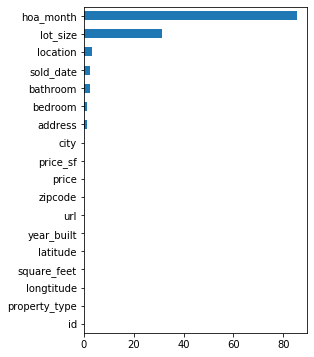

In [14]:
# check missing values
missing_rate = df_2.isnull().sum()/df_2.shape[0]*100
print(missing_rate.sort_values())
missing_rate.sort_values().plot.barh(figsize = (4, 6))

- According to the the bar chart above, more than 90% percent of HOA/month is missing, this feature would be removed.
- Although more than 30% of the feature "LOT size" is missing, the house may not have lot. The missing of this feature can be filled with 0.
- The percentage of missing values of 'sold date', 'baths' and 'beds' are not big, and these features are important in model. So the records with missing values of these features should be dropped. 

In [15]:
df_2.drop('hoa_month', axis = 1, inplace = True)
df_2.dropna(subset = ['sold_date', 'bedroom', 'bathroom'], inplace = True)
df_2.shape

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(10694, 17)

- Categorical variables: 7
- Numerical variables: 11
- date variable: 1

In [16]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10694 entries, 0 to 11182
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sold_date      10694 non-null  object 
 1   property_type  10694 non-null  object 
 2   address        10560 non-null  object 
 3   city           10685 non-null  object 
 4   zipcode        10689 non-null  float64
 5   price          10694 non-null  float64
 6   bedroom        10694 non-null  float64
 7   bathroom       10694 non-null  float64
 8   location       10626 non-null  object 
 9   square_feet    10694 non-null  float64
 10  lot_size       7300 non-null   float64
 11  year_built     10694 non-null  float64
 12  price_sf       10693 non-null  float64
 13  url            10694 non-null  object 
 14  latitude       10694 non-null  float64
 15  longtitude     10694 non-null  float64
 16  id             10694 non-null  object 
dtypes: float64(10), object(7)
memory usage: 1.5+ MB


In [17]:
df_2.tail(3)

,sold_date,property_type,address,city,zipcode,price,bedroom,bathroom,location,square_feet,lot_size,year_built,price_sf,url,latitude,longtitude,id
11180,January-28-2018,Condo/Co-op,189-34 37 Ave Unit 2Fl,Flushing,11358.0,490000.0,1.0,1.0,Bayside West Condo,850.0,NaN,1935.0,576.0,http://www.redfin.com/NY/Unknown/189-34-37th-A...,40.762203,-73.792048,NY_11180
11181,May-2-2017,Multi-Family (2-4 Unit),42-27 167 St,Flushing,11365.0,1950000.0,5.0,4.0,Flushing,3000.0,6000.0,1935.0,650.0,http://www.redfin.com/NY/Flushing/4227-167-St-...,40.758522,-73.799224,NY_11181
11182,May-8-2018,Single Family Residential,41-22 169th St,Flushing,11358.0,1250000.0,4.0,4.5,Flushing,3000.0,4300.0,1940.0,417.0,http://www.redfin.com/NY/Flushing/41-22-169th-...,40.759423,-73.797794,NY_11182


 - EDA of 'property type' and 'city'
- There're 5 'property type', one-hot encoder is a good way to encode this variable.  
- 99 cities totally. This variable will not be used in first model, because 'longtitude' and latitude can represent information of location.

In [18]:
df_2.groupby('property_type').count()

,sold_date,address,city,zipcode,price,bedroom,bathroom,location,square_feet,lot_size,year_built,price_sf,url,latitude,longtitude,id
property_type,,,,,,,,,,,,,,,,
Condo/Co-op,3692,3653,3690,3691,3692,3692,3692,3634,3692,479,3692,3692,3692,3692,3692,3692
Multi-Family (2-4 Unit),2072,2022,2072,2072,2072,2072,2072,2071,2072,1996,2072,2072,2072,2072,2072,2072
Multi-Family (5+ Unit),43,43,43,43,43,43,43,43,43,42,43,43,43,43,43,43
Single Family Residential,3636,3603,3630,3632,3636,3636,3636,3628,3636,3544,3636,3635,3636,3636,3636,3636
Townhouse,1251,1239,1250,1251,1251,1251,1251,1250,1251,1239,1251,1251,1251,1251,1251,1251


In [19]:
df_3 = df_2[~df_2['property_type'].isin(['Multi-Family (5+ Unit)', 'Unknown', 'Vacant Land'])]

In [20]:
df_3.groupby('property_type').count()

,sold_date,address,city,zipcode,price,bedroom,bathroom,location,square_feet,lot_size,year_built,price_sf,url,latitude,longtitude,id
property_type,,,,,,,,,,,,,,,,
Condo/Co-op,3692,3653,3690,3691,3692,3692,3692,3634,3692,479,3692,3692,3692,3692,3692,3692
Multi-Family (2-4 Unit),2072,2022,2072,2072,2072,2072,2072,2071,2072,1996,2072,2072,2072,2072,2072,2072
Single Family Residential,3636,3603,3630,3632,3636,3636,3636,3628,3636,3544,3636,3635,3636,3636,3636,3636
Townhouse,1251,1239,1250,1251,1251,1251,1251,1250,1251,1239,1251,1251,1251,1251,1251,1251


In [21]:
df_3.groupby(['city', 'property_type']).count().sort_values(by = 'sold_date', ascending = False)[0:50]

sold_date  address  zipcode  \
city               property_type                                            
Staten Island      Single Family Residential       1868     1864     1868   
Bronx              Condo/Co-op                     1252     1252     1252   
                   Multi-Family (2-4 Unit)          980      979      980   
                   Single Family Residential        681      680      681   
Staten Island      Townhouse                        666      666      666   
Flushing           Condo/Co-op                      223      219      223   
Staten Island      Condo/Co-op                      157      157      157   
Bayside            Condo/Co-op                      155      151      155   
Brooklyn           Multi-Family (2-4 Unit)          154      149      154   
Kew Gardens        Condo/Co-op                      143      143      143   
Jackson Heights    Condo/Co-op                      141      132      141   
Brooklyn           Condo/Co-op                      140      139      140   
                   Townhouse                        123      123      123   
Rego Park          Condo/Co-op                      122      121      122   
Forest Hills       Condo/Co-op                      116      114      116   
Floral Park        Condo/Co-op                      110      110      110   
Queens Village     Single Family Residential         98       97       98   
New York           Condo/Co-op                       97       97       97   
Elmhurst           Condo/Co-op                       86       84       86   
Flushing           Single Family Residential         80       80       80   
Brooklyn           Single Family Residential         79       79       79   
Glen Oaks          Condo/Co-op                       73       73       73   
Bronx              Townhouse                         72       72       72   
Bayside            Single Family Residential         64       59       64   
Woodside           Condo/Co-op                       63       60       63   
College Point      Multi-Family (2-4 Unit)           62       55       62   
Fresh Meadows      Single Family Residential         61       58       61   
Astoria            Multi-Family (2-4 Unit)           60       59       60   
Maspeth            Multi-Family (2-4 Unit)           59       57       59   
Astoria            Condo/Co-op                       58       58       58   
Little Neck        Condo/Co-op                       57       57       57   
Briarwood          Condo/Co-op                       56       55       56   
Beechhurst         Condo/Co-op                       54       53       54   
Ozone Park         Multi-Family (2-4 Unit)           53       52       53   
Kew Garden Hills   Condo/Co-op                       52       51       52   
Flushing           Multi-Family (2-4 Unit)           50       46       50   
Jamaica            Multi-Family (2-4 Unit)           48       48       48   
                   Single Family Residential         46       46       46   
Bayside            Multi-Family (2-4 Unit)           44       37       44   
College Point      Condo/Co-op                       43       39       43   
Woodhaven          Multi-Family (2-4 Unit)           40       39       40   
E. Elmhurst        Condo/Co-op                       37       36       37   
S. Ozone Park      Single Family Residential         37       36       37   
College Point      Single Family Residential         37       34       37   
call Listing Agent Condo/Co-op                       36       36       36   
Douglaston         Condo/Co-op                       36       36       36   
Flushing           Townhouse                         35       35       35   
Whitestone         Condo/Co-op                       35       35       35   
Rockaway Park      Condo/Co-op                       34       34       34   
Woodside           Multi-Family (2-4 Unit)           34       30       34   

                                         

In [22]:
df_3.groupby('bedroom').count()

,sold_date,property_type,address,city,zipcode,price,bathroom,location,square_feet,lot_size,year_built,price_sf,url,latitude,longtitude,id
bedroom,,,,,,,,,,,,,,,,
0.0,232,232,229,232,232,232,232,229,232,39,232,231,232,232,232,232
1.0,1631,1631,1611,1631,1631,1631,1631,1602,1631,237,1631,1631,1631,1631,1631,1631
2.0,2008,2008,1990,2005,2007,2008,2008,1985,2008,749,2008,2008,2008,2008,2008,2008
3.0,3263,3263,3229,3260,3260,3263,3263,3252,3263,2839,3263,3263,3263,3263,3263,3263
4.0,1513,1513,1497,1512,1512,1513,1513,1512,1513,1455,1513,1513,1513,1513,1513,1513
5.0,837,837,818,835,837,837,837,836,837,810,837,837,837,837,837,837
6.0,645,645,631,645,645,645,645,645,645,626,645,645,645,645,645,645
7.0,236,236,231,236,236,236,236,236,236,228,236,236,236,236,236,236
8.0,166,166,164,166,166,166,166,166,166,161,166,166,166,166,166,166


In [23]:
df_3.groupby('bathroom').count()

,sold_date,property_type,address,city,zipcode,price,bedroom,location,square_feet,lot_size,year_built,price_sf,url,latitude,longtitude,id
bathroom,,,,,,,,,,,,,,,,
0.25,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.50,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
1.00,3231,3231,3197,3230,3230,3231,3231,3189,3231,844,3231,3230,3231,3231,3231,3231
1.25,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
1.50,676,676,664,676,676,676,676,675,676,483,676,676,676,676,676,676
1.75,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
2.00,3046,3046,3016,3043,3044,3046,3046,3025,3046,2433,3046,3046,3046,3046,3046,3046
2.25,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2.50,758,758,747,758,758,758,758,757,758,647,758,758,758,758,758,758


In [24]:
df_4 = df_3[(df_3.bedroom < 9) & (df_3.bedroom > 0) & (df_3.bathroom <= 6) & (df_3.bathroom >= 1)]

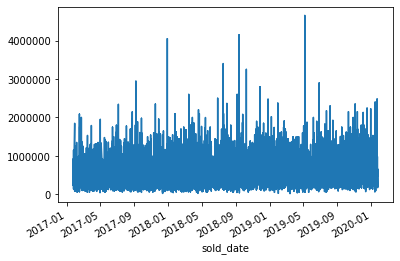

In [25]:
purchase_date = pd.to_datetime(df_4['sold_date'])
price = df_4.price
price.index = purchase_date

price.plot()

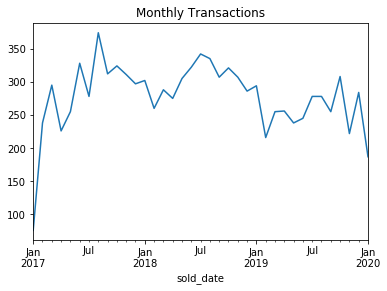

In [26]:
price.resample('M').count().plot(title = 'Monthly Transactions')

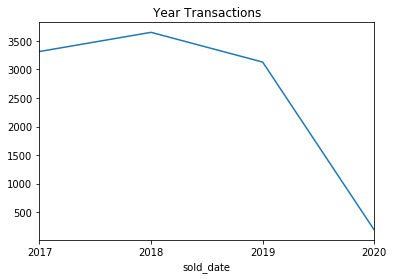

In [27]:
price.resample('Y').count().plot(title = 'Year Transactions')

In [28]:
# fill missing value of 'LOT SIZE' with 0, means the house didn't have 'LOT'
df_4['lot_size'] = df_4['lot_size'].fillna(0)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
df_4['purchase_date'] = purchase_date
df_4['month'] = df_4['purchase_date'].dt.month

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
train_raw = df_4[purchase_date.between('2017-01-01', '2019-06-30')].reset_index(drop = True)
test_raw = df_4[purchase_date.between('2019-07-01', '2020-01-30')].reset_index(drop = True)

In [31]:
train_raw.columns

Index(['sold_date', 'property_type', 'address', 'city', 'zipcode', 'price',
       'bedroom', 'bathroom', 'location', 'square_feet', 'lot_size',
       'year_built', 'price_sf', 'url', 'latitude', 'longtitude', 'id',
       'purchase_date', 'month'],
      dtype='object')

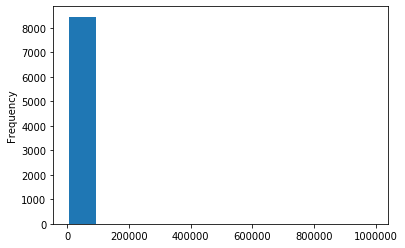

In [32]:
import matplotlib.pyplot as plt
train_raw['square_feet'].plot.hist(bins = 10, rwidth = 0.9)

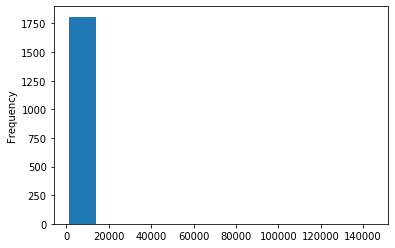

In [33]:
test_raw['square_feet'].plot.hist(bins = 10, rwidth = 0.9)

In [34]:
train_raw['square_feet'].sort_values()

12           9.0
583         12.0
433         17.0
2214        22.0
5205       337.0
          ...   
783     145460.0
4878    285052.0
4187    421800.0
5239    491050.0
5244    994520.0
Name: square_feet, Length: 8468, dtype: float64

In [35]:
test_raw['square_feet'].sort_values()

1386       400.0
870        431.0
195        450.0
148        480.0
61         500.0
          ...   
1186      6600.0
1315      7000.0
1443     16896.0
198      65392.0
196     145446.0
Name: square_feet, Length: 1812, dtype: float64

In [36]:
z_sq = stats.zscore(train_raw['square_feet'])
z_price = stats.zscore(train_raw['price'])

z_sq_test = stats.zscore(test_raw['square_feet'])
z_price_test = stats.zscore(test_raw['price'])

In [37]:
df_5_train = train_raw[(abs(z_sq) < 2) & (abs(z_price) < 2)]
df_5_test = test_raw[(abs(z_sq_test) < 2) & (abs(z_price_test) < 2)]

In [38]:
df_5_train['square_feet'].sort_values()

12          9.0
583        12.0
433        17.0
2214       22.0
5205      337.0
         ...   
114      9500.0
605     10000.0
6532    13569.0
2014    15742.0
1309    24732.0
Name: square_feet, Length: 8114, dtype: float64

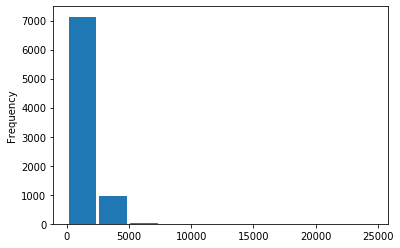

In [39]:
df_5_train['square_feet'].plot.hist(bins = 10, rwidth = 0.9)

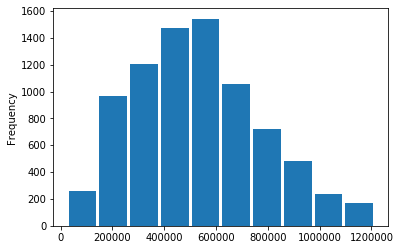

In [40]:
df_5_train['price'].plot.hist(bins = 10, rwidth = 0.9)

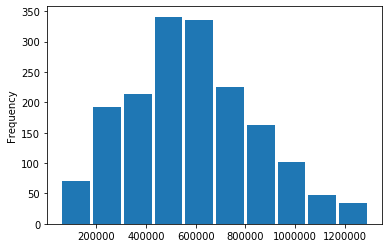

In [41]:
df_5_test['price'].plot.hist(bins = 10, rwidth = 0.9)

In [42]:
df_5_train['year_built'].sort_values()[0:10]

3422    1010.0
751     1025.0
8007    1055.0
141     1195.0
874     1845.0
7009    1848.0
6908    1859.0
822     1870.0
3918    1880.0
7542    1880.0
Name: year_built, dtype: float64

In [43]:
df_6_train = df_5_train[(df_5_train['year_built'] < 2020) & (df_5_train['year_built'] > 1800)]
df_6_test = df_5_test[(df_5_test['year_built'] < 2020) & (df_5_test['year_built'] > 1800)]

- There're too many observations, so there's no obvious pattern in the plot below.

- From 2017 to 2019, the transactions in Redfin dropped year by year.
- August and September had the peak transactions in 2017 and 2018, but they didn't get the highest transactions in 2019.

In [44]:
print(purchase_date.min(), purchase_date.max())

2017-01-25 00:00:00 2020-01-24 00:00:00


In [45]:
df_6_train.columns

Index(['sold_date', 'property_type', 'address', 'city', 'zipcode', 'price',
       'bedroom', 'bathroom', 'location', 'square_feet', 'lot_size',
       'year_built', 'price_sf', 'url', 'latitude', 'longtitude', 'id',
       'purchase_date', 'month'],
      dtype='object')

In [46]:
df_7_train = df_6_train[['purchase_date', 'month', 'property_type', 'price', 'bedroom', 'bathroom',
            'square_feet', 'lot_size', 'year_built', 'latitude', 'longtitude']]
df_8_train = pd.get_dummies(df_7_train)

In [47]:
df_8_train.columns

Index(['purchase_date', 'month', 'price', 'bedroom', 'bathroom', 'square_feet',
       'lot_size', 'year_built', 'latitude', 'longtitude',
       'property_type_Condo/Co-op', 'property_type_Multi-Family (2-4 Unit)',
       'property_type_Single Family Residential', 'property_type_Townhouse'],
      dtype='object')

In [48]:
df_8_train.rename(columns = {'property_type_Condo/Co-op':'condo',
                  'property_type_Multi-Family (2-4 Unit)':'multi_family',
                   'property_type_Single Family Residential':'single_family',
                    'property_type_Townhouse' : 'townhouse'}, inplace = True)

(9.5, -0.5)

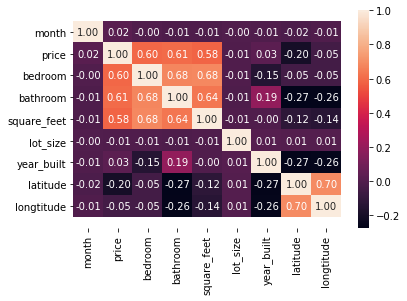

In [49]:
import seaborn as sns
ax = sns.heatmap(df_7_train.corr(), annot = True, fmt= ".2f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [50]:
df_7_test = df_6_test[['purchase_date', 'month', 'property_type', 'price', 'bedroom', 'bathroom',
            'square_feet', 'lot_size', 'year_built', 'latitude', 'longtitude']]
df_8_test = pd.get_dummies(df_7_test)
df_8_test.rename(columns = {'property_type_Condo/Co-op':'condo',
                  'property_type_Multi-Family (2-4 Unit)':'multi_family',
                   'property_type_Single Family Residential':'single_family',
                    'property_type_Townhouse' : 'townhouse'}, inplace = True)

In [51]:
train = df_8_train.drop('purchase_date', axis = 1)
features = list(train.columns)
target = 'price'
features.remove(target)

X_train = train[features]
y_train = train[target]

In [98]:
y_train_log = y_train.map(lambda x: np.log(x + 1))

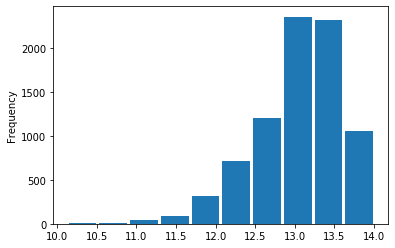

In [108]:
y_train_log.plot.hist(bins = 10, rwidth = 0.9)

In [52]:
X_train.shape

(8108, 12)

In [53]:
#test = df_8_test.drop('purchase_date', axis = 1)
X_test = df_8_test[features]
y_test = df_8_test[target]

In [99]:
y_test_log = y_test.map(lambda x: np.log(x + 1))

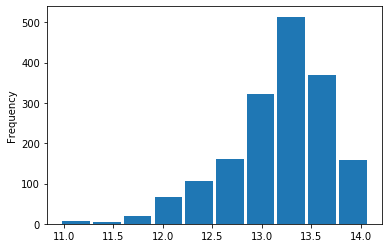

In [109]:
y_test_log.plot.hist(bins = 10, rwidth = 0.9)

In [54]:
X_test.shape

(1725, 12)

In [55]:
X_train.head(3)

,month,bedroom,bathroom,square_feet,lot_size,year_built,latitude,longtitude,condo,multi_family,single_family,townhouse
0,12,2.0,2.0,1017.0,0.0,1989.0,40.647620,-73.886807,1,0,0,0
1,6,2.0,2.0,800.0,0.0,1987.0,40.637119,-73.900574,1,0,0,0
2,5,3.0,2.0,1280.0,2351.0,1920.0,40.639098,-73.895921,0,0,0,1


In [56]:
X_train.columns

Index(['month', 'bedroom', 'bathroom', 'square_feet', 'lot_size', 'year_built',
       'latitude', 'longtitude', 'condo', 'multi_family', 'single_family',
       'townhouse'],
      dtype='object')

In [57]:
from sklearn.linear_model import LinearRegression

In [100]:
from sklearn.pipeline import Pipeline
steps=[('rescale', MinMaxScaler()),
    ('lr', LinearRegression())]

model = Pipeline(steps=steps)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MSE: 2.88e+10
train MAE: 1.31e+05
train R2: 0.515
test MSE: 3.28e+11
test MAE: 5.48e+05
test R2: -1283023143625.413


In [105]:
# log
steps=[('rescale', MinMaxScaler()),
    ('lr', LinearRegression())]

model = Pipeline(steps=steps)
model.fit(X_train, y_train_log)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print('train MSE: {0:.2f}'.format(mean_squared_error(y_train_log, y_train_pred)))
print('train MAE: {0:.2f}'.format(mean_absolute_error(y_train_log, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train_log, y_train_pred)))

print('test MSE: {0:.2f}'.format(mean_squared_error(y_test_log, y_test_pred)))
print('test MAE: {0:.2f}'.format(mean_absolute_error(y_test_log, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test_log, y_test_pred)))

train MSE: 0.14
train MAE: 0.28
train R2: 0.532
test MSE: 0.12
test MAE: 0.27
test R2: 0.517


Text(0, 0.5, 'y_test_pred')

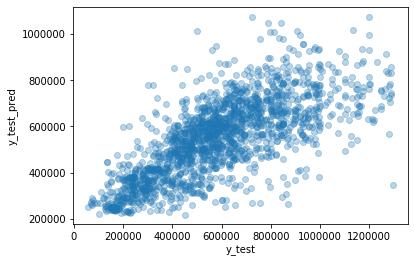

In [59]:
plt.scatter(y_test, y_test_pred, alpha = 0.3)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')

In [106]:
# log
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

steps=[('rescale', MinMaxScaler()),
    ('rfr', RandomForestRegressor())]

model = Pipeline(steps=steps)
model.fit(X_train, y_train_log)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


print('train MSE: {0:.2f}'.format(mean_squared_error(y_train_log, y_train_pred)))
print('train MAE: {0:.2f}'.format(mean_absolute_error(y_train_log, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train_log, y_train_pred)))

print('test MSE: {0:.2f}'.format(mean_squared_error(y_test_log, y_test_pred)))
print('test MAE: {0:.2f}'.format(mean_absolute_error(y_test_log, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test_log, y_test_pred)))

train MSE: 0.01
train MAE: 0.05
train R2: 0.981
test MSE: 0.04
test MAE: 0.15
test R2: 0.828


Text(0, 0.5, 'y_test_pred')

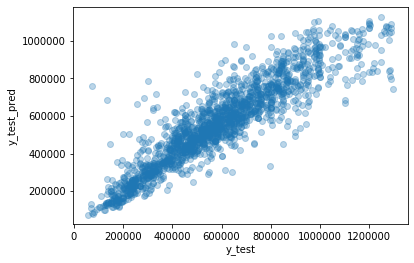

In [61]:
plt.scatter(y_test, y_test_pred, alpha = 0.3)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')

In [103]:
import pickle
with open('house_predict.pkl', 'wb') as f:
    pickle.dump(model, f)

In [107]:
steps=[('rescale', MinMaxScaler()),
    ('xgbr', XGBRegressor())]

model = Pipeline(steps=steps)
model.fit(X_train, y_train_log)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


print('train MSE: {0:.2f}'.format(mean_squared_error(y_train_log, y_train_pred)))
print('train MAE: {0:.2f}'.format(mean_absolute_error(y_train_log, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train_log, y_train_pred)))

print('test MSE: {0:.2f}'.format(mean_squared_error(y_test_log, y_test_pred)))
print('test MAE: {0:.2f}'.format(mean_absolute_error(y_test_log, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test_log, y_test_pred)))

[14:23:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train MSE: 0.05
train MAE: 0.16
train R2: 0.836
test MSE: 0.05
test MAE: 0.17
test R2: 0.795


Text(0, 0.5, 'y_test_pred')

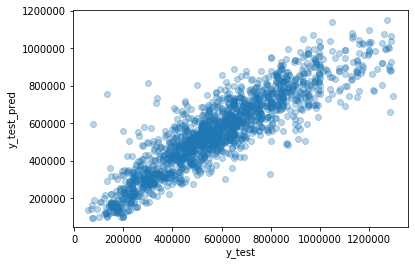

In [87]:
plt.scatter(y_test, y_test_pred, alpha = 0.3)
plt.xlabel('y_test')
plt.ylabel('y_test_pred')

In [63]:
pct = (y_test_pred - y_test)/y_test
(abs(pct) < 0.1).sum()/len(pct)

0.49391304347826087

In [65]:
model.steps

[('rescale', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('rfr', RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        max_samples=None, min_impurity_decrease=0.0,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=100, n_jobs=None, oob_score=False,
                        random_state=None, verbose=0, warm_start=False))]

In [64]:
X_train.columns

Index(['month', 'bedroom', 'bathroom', 'square_feet', 'lot_size', 'year_built',
       'latitude', 'longtitude', 'condo', 'multi_family', 'single_family',
       'townhouse'],
      dtype='object')

In [69]:
model.steps[1][1].feature_importances_

array([0.01460465, 0.01794334, 0.04756677, 0.47674566, 0.05338549,
       0.05740425, 0.21574062, 0.09553952, 0.00920598, 0.00641525,
       0.0033813 , 0.00206718])

In [75]:
col = X_train.columns
fi = model.steps[1][1].feature_importances_

In [81]:
col = pd.DataFrame(X_train.columns)
fi = pd.DataFrame(model.steps[1][1].feature_importances_)

In [92]:
fi.columns = ['fei']

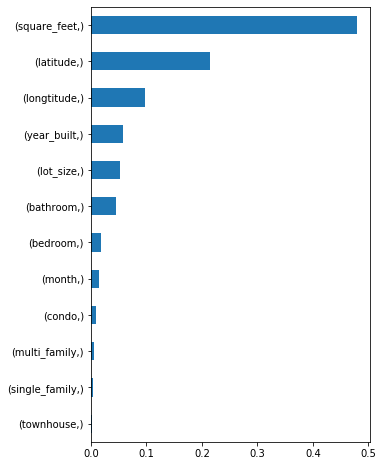

In [94]:
fi.fei.sort_values().plot.barh(figsize = (5, 8))